## 朴素贝叶斯 ##

朴素贝叶斯方法是一组基于贝叶斯定理的有监督学习算法，其“朴素”假设是给定类变量值的每一对特征之间存在条件独立性。贝叶斯定理给出了给定类变量$y$与相关特征向量$x_1$到$x_n$的关系:
$$P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots x_n \mid y)}
                                 {P(x_1, \dots, x_n)}$$
使用朴素条件独立假设:
$$P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y)$$
对于所有$i$，这个关系被简化为：
$$
\begin{align}\begin{aligned}P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)\\\Downarrow\\\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),\end{aligned}\end{align}
$$
我们可以使用极大后验(MAP)估计来估计$P(y)$和$P(x_i\mid y)$;前者则为训练集中y类的相对频率。不同的朴素贝叶斯分类器的差异主要在于它们对$P(x_i\mid y)$分布的假设不同。

![朴素贝叶斯分类](朴素贝叶斯分类.png)

尽管朴素贝叶斯分类器的假设明显过于简化，但它们在许多实际情况下都能很好地工作，比如著名的文档分类和垃圾邮件过滤。它们需要少量的训练数据来估计必要的参数。


事实上,概率模型的训练过程就是参数估计(parameter estimation)过程。对于参数估计,统计学界的两个学派分别提供了不同的解决方案:频率主义学派(Frequentist)认为参数虽然未知,但却是客观存在的固定值,因此,可通过优化似然函数等准则来确定参数值;贝叶斯学派(Bayesian)则认为参数是未观察到的随机变量,其本身也可有分布,因此,可假定参数服从一个先验分布,然后基于观测到的数据来计算参数的后验分布.本节介绍源自频率主义学派的极大似然估计(Maximum Likelihood Estimation,简称MLE),这是根据数据采样来估计概率分布参数的经典方法.


### NB的优点和缺点 ###
与更复杂的方法相比，朴素贝叶斯学习器和分类器可以非常快。类条件特征分布的解耦意味着每个分布都可以独立地估计为一维分布。这反过来又有助于缓解来自维度诅咒的问题。

另一方面，尽管朴素贝叶斯被认为是一个不错的分类器，但它是一个糟糕的估计器，所以来自*predict_proba*的概率输出不需要太认真对待。


### 朴素高斯贝叶斯 ###
假设类条件概率服从高斯分布，其概率密度函数为： $$P(x_i | y_k)=\frac{1}{\sqrt{2\pi\sigma^2_{y_k}}}exp(-\frac{(x_i-\mu_{y_k})^2}{2\sigma^2_{y_k}})$$ 数学期望(mean)：$\mu$，方差：$\sigma^2=\frac{\sum(X-\mu)^2}{N}$, 可以利用MLE对$\mu$和$\sigma^2$进行参数估计。下面展示了该模型的实现代码：

In [3]:
#Compute the log of the sum of exponentials of input elements
from scipy.special import  logsumexp
#View inputs as arrays with at least two dimensions.
#np.atleast_2d
from sklearn import datasets
#from sklearn.naive_bayes import GaussianNB
import numpy as np
from abc import ABCMeta, abstractmethod

In [4]:
class BaseNB(metaclass=ABCMeta):
    
    @abstractmethod
    def _joint_log_likelihood(self, X):
        """
        计算没有被归一化的后验概率的对数 I.e. ``log P(c) + log P(x|c)``, 右边分子部分
        Returns: [n_sample, n_classes]
        """
        pass
    def predict(self, X):
        """
        X : array-like, shape = [n_samples, n_features]
        """
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]

    def predict_log_proba(self, X):
        """
        X : array-like, shape = [n_samples, n_features]
        Returns : array-like, shape = [n_samples, n_classes]
        """
        jll = self._joint_log_likelihood(X)
        log_prob_x = logsumexp(jll, axis=1)
        return jll - np.atleast_2d(log_prob_x).T

    def predict_proba(self, X):
        """
        X : array-like, shape = [n_samples, n_features]
        Returns : array-like, shape = [n_samples, n_classes]
        """
        return np.exp(self.predict_log_proba(X))

In [5]:
class GaussianNB(BaseNB):
    def __init__(self, priors=None, var_smoothing=1e-9):
        self.priors = priors
        self.var_smoothing = var_smoothing
    def _get_mean_variance(self, X, sample_weight=None):
        # Compute (potentially weighted) mean and variance of new datapoints
        if sample_weight is not None:
            n_new = float(sample_weight.sum())
            new_mu = np.average(X, axis=0, weights=sample_weight / n_new)
            new_var = np.average((X - new_mu) ** 2, axis=0,
                                 weights=sample_weight / n_new)
        else:
            n_new = X.shape[0]
            new_var = np.var(X, axis=0)
            new_mu = np.mean(X, axis=0)

        return new_mu, new_var
    def fit(self, X, y, sample_weight=None):
        # If the ratio of data variance between dimensions is too small, it
        # will cause numerical errors. To address this, we artificially
        # boost the variance by epsilon, a small fraction of the standard
        # deviation of the largest dimension.
        self.epsilon_ = self.var_smoothing * np.var(X, axis=0).max()
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        n_classes = len(self.classes_)
        self.theta_ = np.zeros((n_classes, n_features))
        self.sigma_ = np.zeros((n_classes, n_features))
        self.class_count_ = np.zeros(n_classes, dtype=np.float64)

        for (i, y_i) in enumerate(self.classes_):
            X_i = X[y == y_i, :]
            if sample_weight is not None:
                sw_i = sample_weight[y == y_i]
                N_i = sw_i.sum()
            else:
                sw_i = None
                N_i = X_i.shape[0]
            self.theta_[i, :], self.sigma_[i, :] = self._get_mean_variance(X_i, sw_i)
            self.class_count_[i] += N_i
        self.sigma_[:, :] += self.epsilon_

        # Set priors 
        if self.priors:
            self.class_prior_ = np.asarray(self.priors)
        else:
            # Empirical prior, with sample_weight taken into account
            self.class_prior_ = self.class_count_ / self.class_count_.sum()
        return self
    
    def _joint_log_likelihood(self, X):
        joint_log_likelihood = []
        for i in range(np.size(self.classes_)):
            jointi = np.log(self.class_prior_[i])
            n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
            n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
                                 (self.sigma_[i, :]), 1)
            joint_log_likelihood.append(jointi + n_ij)

        joint_log_likelihood = np.array(joint_log_likelihood).T
        return joint_log_likelihood

In [6]:
iris = datasets.load_iris()
gnb = GaussianNB(priors=[.3, .2, .5])
gnb.fit(iris.data, iris.target)
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)
#gnb.predict_proba(iris.data)
(y_pred == iris.target).sum() / len(iris.target)

0.95333333333333337

## SVM ##

训练数据集
\begin{align*} \\& T = \left\{ \left( x_{1}, y_{1} \right), \left( x_{2}, y_{2} \right), \cdots, \left( x_{N}, y_{N} \right) \right\} \end{align*}   
其中，$x_{i} \in \mathcal{X} = R^{n}, y_{i} \in \mathcal{Y} = \left\{ +1, -1 \right\}, i = 1, 2, \cdots, N$，$x_{i}$为第$i$个特征向量（实例），$y_{i}$为第$x_{i}$的类标记，当$y_{i}=+1$时，称$x_{i}$为正例；当$y_{i}= -1$时，称$x_{i}$为负例，$\left( x_{i}, y_{i} \right)$称为样本点。

### 线性可分支持向量机（硬间隔支持向量机）### 
给定线性可分训练数据集，通过间隔最大化或等价地求解相应地凸二次规划问题学习得到分离超平面为
\begin{align*} \\& w^{*} \cdot x + b^{*} = 0 \end{align*}   
以及相应的分类决策函数
\begin{align*} \\& f \left( x \right) = sign \left( w^{*} \cdot x + b^{*} \right)  \end{align*}   
称为线型可分支持向量机。

超平面$\left( w, b \right)$关于样本点$\left( x_{i}, y_{i} \right)$的函数间隔为
\begin{align*} \\& \hat \gamma_{i} = y_{i} \left( w \cdot x_{i} + b \right) \end{align*}  

超平面$\left( w, b \right)$关于训练集$T$的函数间隔
\begin{align*} \\& \hat \gamma = \min_{i = 1, 2, \cdots, N} \hat \gamma_{i} \end{align*}   
即超平面$\left( w, b \right)$关于训练集$T$中所有样本点$\left( x_{i}, y_{i} \right)$的函数间隔的最小值。

超平面$\left( w, b \right)$关于样本点$\left( x_{i}, y_{i} \right)$的几何间隔为
 \begin{align*} \\& \gamma_{i} = y_{i} \left( \dfrac{w}{\| w \|} \cdot x_{i} + \dfrac{b}{\| w \|} \right) \end{align*}   

超平面$\left( w, b \right)$关于训练集$T$的几何间隔
\begin{align*} \\& \gamma = \min_{i = 1, 2, \cdots, N} \gamma_{i} \end{align*}   
即超平面$\left( w, b \right)$关于训练集$T$中所有样本点$\left( x_{i}, y_{i} \right)$的几何间隔的最小值。

函数间隔和几何间隔的关系
\begin{align*} \\& \gamma_{i} = \dfrac{\hat \gamma_{i}}{\| w \|} 
\\& \gamma = \dfrac{\hat \gamma}{\| w \|} \end{align*} 

最大间隔分离超平面等价为求解
\begin{align*} \\& \max_{w,b} \quad \gamma
\\ & s.t. \quad y_{i} \left( \dfrac{w}{\| w \|} \cdot x_{i} + \dfrac{b}{\| w \|} \right) \geq \gamma, \quad i=1,2, \cdots, N \end{align*}  
等价的
\begin{align*}  \\ & \max_{w,b} \quad \dfrac{\hat \gamma}{\| w \|}
\\ & s.t. \quad y_{i} \left( w \cdot x_{i} + b \right) \geq \hat \gamma, \quad i=1,2, \cdots, N \end{align*}   
等价的
\begin{align*}  \\ & \min_{w,b} \quad \dfrac{1}{2} \| w \|^{2}
\\ & s.t. \quad y_{i} \left( w \cdot x_{i} + b \right) -1 \geq 0, \quad i=1,2, \cdots, N \end{align*}   

线性可分支持向量机学习算法（最大间隔法）：  
输入：线性可分训练数据集$T = \left\{ \left( x_{1}, y_{1} \right), \left( x_{2}, y_{2} \right), \cdots, \left( x_{N}, y_{N} \right) \right\}$，其中$x_{i} \in \mathcal{X} = R^{n}, y_{i} \in \mathcal{Y} = \left\{ +1, -1 \right\}, i = 1, 2, \cdots, N$  
输出：最大间隔分离超平面和分类决策函数  
1. 构建并求解约束最优化问题
\begin{align*}  \\ & \min_{w,b} \quad \dfrac{1}{2} \| w \|^{2}
\\ & s.t. \quad y_{i} \left( w \cdot x_{i} + b \right) -1 \geq 0, \quad i=1,2, \cdots, N \end{align*}   
求得最优解$w^{*}, b^{*}$。  
2. 得到分离超平面
\begin{align*}  \\ & w^{*} \cdot x + b^{*} = 0 \end{align*}   
以及分类决策函数  
\begin{align*} \\& f \left( x \right) = sign \left( w^{*} \cdot x + b^{*} \right)  \end{align*}  

（硬间隔）支持向量：训练数据集的样本点中与分离超平面距离最近的样本点的实例，即使约束条件等号成立的样本点
\begin{align*} \\ & y_{i} \left( w \cdot x_{i} + b \right) -1 = 0 \end{align*}    
对$y_{i} = +1$的正例点，支持向量在超平面  
\begin{align*} \\ & H_{1}:w \cdot x + b = 1  \end{align*}  
对$y_{i} = -1$的正例点，支持向量在超平面  
\begin{align*} \\ & H_{1}:w \cdot x + b = -1  \end{align*}     
$H_{1}$和$H_{2}$称为间隔边界。  
$H_{1}$和$H_{2}$之间的距离称为间隔，且$|H_{1}H_{2}| = \dfrac{1}{\| w \|} + \dfrac{1}{\| w \|} = \dfrac{2}{\| w \|}$。

最优化问题的求解：  
1. 引入拉格朗日乘子$\alpha_{i} \geq 0, i = 1, 2, \cdots, N$构建拉格朗日函数
\begin{align*} \\ & L \left( w, b, \alpha \right) =  \dfrac{1}{2} \| w \|^{2} + \sum_{i=1}^{N} \alpha_{i} \left[- y_{i} \left( w \cdot x_{i} + b \right) + 1  \right] 
\\ & = \dfrac{1}{2} \| w \|^{2} - \sum_{i=1}^{N} \alpha_{i}  y_{i} \left( w \cdot x_{i} + b \right) + \sum_{i=1}^{N} \alpha_{i}  \end{align*}    
其中，$\alpha = \left( \alpha_{1}, \alpha_{2}, \cdots, \alpha_{N} \right)^{T}$为拉格朗日乘子向量。
2. 求$\min_{w,b}L \left( w, b, \alpha \right)$:
\begin{align*} \\ &  \nabla _{w} L \left( w, b, \alpha \right) = w - \sum_{i=1}^{N} \alpha_{i} y_{i} x_{i} = 0 
\\ &  \nabla _{b} L \left( w, b, \alpha \right) = -\sum_{i=1}^{N} \alpha_{i} y_{i} = 0 \end{align*}   
得  
\begin{align*} \\ &   w ＝ \sum_{i=1}^{N} \alpha_{i} y_{i} x_{i}  
\\ &  \sum_{i=1}^{N} \alpha_{i} y_{i} = 0 \end{align*}   
代入拉格朗日函数，得
\begin{align*} \\ & L \left( w, b, \alpha \right) =  \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right) - \sum_{i=1}^{N} \alpha_{i}  y_{i} \left[ \left( \sum_{j=1}^{N} \alpha_{j} y_{j} x_{j} \right) \cdot x_{i} + b \right] + \sum_{i=1}^{N} \alpha_{i} 
\\ & = - \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right) - \sum_{i=1}^{N} \alpha_{i} y_{i} b + \sum_{i=1}^{N} \alpha_{i} 
\\ & = - \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  + \sum_{i=1}^{N} \alpha_{i} \end{align*}    
即
\begin{align*} \\ & \min_{w,b}L \left( w, b, \alpha \right) = - \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  + \sum_{i=1}^{N} \alpha_{i}    \end{align*} 
3.求$\max_{\alpha} \min_{w,b}L \left( w, b, \alpha \right)$:
\begin{align*} \\ &  \max_{\alpha} - \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  + \sum_{i=1}^{N} \alpha_{i}  
\\ & s.t. \sum_{i=1}^{N} \alpha_{i} y_{i} = 0
\\ & \alpha_{i} \geq 0, \quad i=1,2, \cdots, N  \end{align*}    
等价的
\begin{align*} \\ &  \min_{\alpha} \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  - \sum_{i=1}^{N} \alpha_{i}  
\\ & s.t. \sum_{i=1}^{N} \alpha_{i} y_{i} = 0
\\ & \alpha_{i} \geq 0, \quad i=1,2, \cdots, N  \end{align*} 

线性可分支持向量机（硬间隔支持向量机）学习算法：  
输入：线性可分训练数据集$T = \left\{ \left( x_{1}, y_{1} \right), \left( x_{2}, y_{2} \right), \cdots, \left( x_{N}, y_{N} \right) \right\}$，其中$x_{i} \in \mathcal{X} = R^{n}, y_{i} \in \mathcal{Y} = \left\{ +1, -1 \right\}, i = 1, 2, \cdots, N$  
输出：最大间隔分离超平面和分类决策函数  
1. 构建并求解约束最优化问题
\begin{align*} \\ &  \min_{\alpha} \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  - \sum_{i=1}^{N} \alpha_{i}  
\\ & s.t. \sum_{i=1}^{N} \alpha_{i} y_{i} = 0
\\ & \alpha_{i} \geq 0, \quad i=1,2, \cdots, N  \end{align*}    
求得最优解$\alpha^{*} = \left( \alpha_{1}^{*}, \alpha_{1}^{*}, \cdots, \alpha_{N}^{*} \right) $。  
2. 计算
\begin{align*}  \\ & w^{*} = \sum_{i=1}^{N} \alpha_{i}^{*} y_{i} x_{i} \end{align*}   
并选择$\alpha^{*}$的一个正分量$\alpha_{j}^{*} > 0$，计算
\begin{align*}  \\ & b^{*} = y_{j} - \sum_{i=1}^{N} \alpha_{i}^{*} y_{i} \left( x_{i} \cdot x_{j} \right) \end{align*}  
3. 得到分离超平面
\begin{align*}  \\ & w^{*} \cdot x + b^{*} = 0 \end{align*}   
以及分类决策函数  
\begin{align*} \\& f \left( x \right) = sign \left( w^{*} \cdot x + b^{*} \right)  \end{align*}  

线性支持向量机（软间隔支持向量机）：给定线性不可分训练数据集，通过求解凸二次规划问题  
\begin{align*}  \\ & \min_{w,b,\xi} \quad \dfrac{1}{2} \| w \|^{2} + C \sum_{i=1}^{N} \xi_{i}
\\ & s.t. \quad y_{i} \left( w \cdot x_{i} + b \right) \geq 1 - \xi_{i}
\\ & \xi_{i} \geq 0, \quad i=1,2, \cdots, N \end{align*}  
学习得到分离超平面为
\begin{align*} \\& w^{*} \cdot x + b^{*} = 0 \end{align*}   
以及相应的分类决策函数
\begin{align*} \\& f \left( x \right) = sign \left( w^{*} \cdot x + b^{*} \right)  \end{align*}   
称为线型支持向量机。

最优化问题的求解：  
1. 引入拉格朗日乘子$\alpha_{i} \geq 0, \mu_{i} \geq 0, i = 1, 2, \cdots, N$构建拉格朗日函数
\begin{align*} \\ & L \left( w, b, \xi, \alpha, \mu \right) =  \dfrac{1}{2} \| w \|^{2} + C \sum_{i=1}^{N} \xi_{i} + \sum_{i=1}^{N} \alpha_{i} \left[- y_{i} \left( w \cdot x_{i} + b \right) + 1 - \xi_{i}  \right] + \sum_{i=1}^{N} \mu_{i} \left( -\xi_{i} \right)
\\ & = \dfrac{1}{2} \| w \|^{2} + C \sum_{i=1}^{N} \xi_{i} - \sum_{i=1}^{N} \alpha_{i} \left[ y_{i} \left( w \cdot x_{i} + b \right) -1 + \xi_{i} \right] - \sum_{i=1}^{N} \mu_{i} \xi_{i}  \end{align*}    
其中，$\alpha = \left( \alpha_{1}, \alpha_{2}, \cdots, \alpha_{N} \right)^{T}$以及$\mu = \left( \mu_{1}, \mu_{2}, \cdots, \mu_{N} \right)^{T}$为拉格朗日乘子向量。  
2. 求$\min_{w,b}L \left( w, b, \xi, \alpha, \mu \right)$:
\begin{align*} \\ &  \nabla_{w} L \left( w, b, \xi, \alpha, \mu \right) = w - \sum_{i=1}^{N} \alpha_{i} y_{i} x_{i} = 0 
\\ &  \nabla_{b} L \left( w, b, \xi, \alpha, \mu \right) = -\sum_{i=1}^{N} \alpha_{i} y_{i} = 0 
\\ & \nabla_{\xi_{i}} L \left( w, b, \xi, \alpha, \mu \right) = C - \alpha_{i} - \mu_{i} = 0 \end{align*}   
得  
\begin{align*} \\ &   w ＝ \sum_{i=1}^{N} \alpha_{i} y_{i} x_{i}  
\\ &  \sum_{i=1}^{N} \alpha_{i} y_{i} = 0 
\\ & C - \alpha_{i} - \mu_{i} = 0\end{align*}   
代入拉格朗日函数，得
\begin{align*} \\ & L \left( w, b, \xi, \alpha, \mu \right) =  \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right) + C \sum_{i=1}^{N} \xi_{i} - \sum_{i=1}^{N} \alpha_{i}  y_{i} \left[ \left( \sum_{j=1}^{N} \alpha_{j} y_{j} x_{j} \right) \cdot x_{i} + b \right] 
\\ & \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad + \sum_{i=1}^{N} \alpha_{i} - \sum_{i=1}^{N} \alpha_{i} \xi_{i} - \sum_{i}^{N} \mu_{i} \xi_{i}
\\ & = - \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right) - \sum_{i=1}^{N} \alpha_{i} y_{i} b + \sum_{i=1}^{N} \alpha_{i} + \sum_{i=1}^{N} \xi_{i} \left( C - \alpha_{i} - \mu_{i}  \right)
\\ & = - \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  + \sum_{i=1}^{N} \alpha_{i} \end{align*}    
即
\begin{align*} \\ & \min_{w,b,\xi}L \left( w, b, \xi, \alpha, \mu \right) = - \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  + \sum_{i=1}^{N} \alpha_{i}    \end{align*}   
3.求$\max_{\alpha} \min_{w,b, \xi}L \left( w, b, \xi, \alpha, \mu \right)$:
\begin{align*} \\ &  \max_{\alpha} - \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  + \sum_{i=1}^{N} \alpha_{i}  
\\ & s.t. \sum_{i=1}^{N} \alpha_{i} y_{i} = 0
\\ & C - \alpha_{i} - \mu_{i} = 0
\\ & \alpha_{i} \geq 0
\\ & \mu_{i} \geq 0, \quad i=1,2, \cdots, N  \end{align*}    
等价的
\begin{align*} \\ &  \min_{\alpha} \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  - \sum_{i=1}^{N} \alpha_{i}  
\\ & s.t. \sum_{i=1}^{N} \alpha_{i} y_{i} = 0
\\ & 0 \leq \alpha_{i} \leq C , \quad i=1,2, \cdots, N  \end{align*}    

### 线性支持向量机（软间隔支持向量机）学习算法 ###
输入：训练数据集$T = \left\{ \left( x_{1}, y_{1} \right), \left( x_{2}, y_{2} \right), \cdots, \left( x_{N}, y_{N} \right) \right\}$，其中$x_{i} \in \mathcal{X} = R^{n}, y_{i} \in \mathcal{Y} = \left\{ +1, -1 \right\}, i = 1, 2, \cdots, N$  
输出：最大间隔分离超平面和分类决策函数  
1. 选择惩罚参数$C \geq 0$，构建并求解约束最优化问题
\begin{align*} \\ &  \min_{\alpha} \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} \left( x_{i} \cdot x_{j} \right)  - \sum_{i=1}^{N} \alpha_{i}  
\\ & s.t. \sum_{i=1}^{N} \alpha_{i} y_{i} = 0
\\ & 0 \leq \alpha_{i} \leq C , \quad i=1,2, \cdots, N  \end{align*}    
求得最优解$\alpha^{*} = \left( \alpha_{1}^{*}, \alpha_{1}^{*}, \cdots, \alpha_{N}^{*} \right) $。  
2. 计算
\begin{align*}  \\ & w^{*} = \sum_{i=1}^{N} \alpha_{i}^{*} y_{i} x_{i} \end{align*}   
并选择$\alpha^{*}$的一个分量$0 < \alpha_{j}^{*} < C$，计算
\begin{align*}  \\ & b^{*} = y_{j} - \sum_{i=1}^{N} \alpha_{i}^{*} y_{i} \left( x_{i} \cdot x_{j} \right) \end{align*}  
3. 得到分离超平面
\begin{align*}  \\ & w^{*} \cdot x + b^{*} = 0 \end{align*}   
以及分类决策函数  
\begin{align*} \\& f \left( x \right) = sign \left( w^{*} \cdot x + b^{*} \right)  \end{align*}  

（软间隔）支持向量：线性不可分情况下，最优化问题的解$\alpha^{*} = \left( \alpha_{1}^{*}, \alpha_{2}^{*}, \cdots, \alpha_{N}^{*} \right)^{T}$中对应于$\alpha_{i}^{*} > 0$的样本点$\left( x_{i}, y_{i} \right)$的实例$x_{i}$。  

实例$x_{i}$的几何间隔
\begin{align*} \\& \gamma_{i} = \dfrac{y_{i} \left( w \cdot x_{i} + b \right)}{ \| w \|} = \dfrac{| 1 - \xi_{i} |}{\| w \|} \end{align*}    
且$\dfrac{1}{2} | H_{1}H_{2} | = \dfrac{1}{\| w \|}$  
则实例$x_{i}$到间隔边界的距离
\begin{align*} \\& \left| \gamma_{i} - \dfrac{1}{\| w \|} \right| = \left| \dfrac{| 1 - \xi_{i} |}{\| w \|} - \dfrac{1}{\| w \|}  \right| 
\\ & = \dfrac{\xi_{i}}{\| w \|}\end{align*}  
\begin{align*} \xi_{i} \geq 0 \Leftrightarrow \left\{
\begin{aligned} 
\ &  \xi_{i}=0, x_{i}在间隔边界上;
\\ & 0 < \xi_{i} < 1, x_{i}在间隔边界与分离超平面之间;
\\ & \xi_{i}=1, x_{i}在分离超平面上;
\\ & \xi_{i}>1, x_{i}在分离超平面误分类一侧;
\end{aligned}
\right.\end{align*} 

线性支持向量机（软间隔）的合页损失函数
\begin{align*} \\& L \left( y \left( w \cdot x + b \right) \right) = \left[ 1 - y \left(w \cdot x + b \right) \right]_{+} \end{align*}     
其中，“＋”为取正函数
\begin{align*} \left[ z \right]_{+} = \left\{
\begin{aligned} 
\ &  z, z > 0
\\ & 0, z \leq 0
\end{aligned}
\right.\end{align*} 

### 核函数 ###
设$\mathcal{X}$是输入空间（欧氏空间$R^{n}$的子集或离散集合），$\mathcal{H}$是特征空间（希尔伯特空间），如果存在一个从$\mathcal{X}$到$\mathcal{H}$的映射
\begin{align*} \\& \phi \left( x \right) : \mathcal{X} \to \mathcal{H}   \end{align*}  
使得对所有$x,z \in \mathcal{X}$，函数$K \left(x, z \right)$满足条件  
\begin{align*} \\ &  K \left(x, z \right) = \phi \left( x \right) \cdot \phi \left( z \right)  \end{align*}  
则称$K \left(x, z \right)$为核函数，$\phi \left( x \right)$为映射函数，式中$\phi \left( x \right) \cdot \phi \left( z \right)$为$\phi \left( x \right)$和$\phi \left( z \right)$的内积。  

常用核函数：  
1. 多项式核函数
\begin{align*} \\& K \left( x, z \right) = \left( x \cdot z + 1 \right)^{p} \end{align*}   
2. 高斯核函数  
\begin{align*} \\& K \left( x, z \right) = \exp \left( - \dfrac{\| x - z \|^{2}}{2 \sigma^{2}} \right) \end{align*}   

非线性支持向量机：从非线性分类训练集，通过核函数与软间隔最大化，学习得到分类决策函数  
\begin{align*} \\& f \left( x \right) = sign \left( \sum_{i=1}^{N} \alpha_{i}^{*} y_{i} K \left(x, x_{i} \right) + b^{*} \right) \end{align*}  
称为非线性支持向量机，$K \left( x, z \right)$是正定核函数。

### 非线性支持向量机学习算法 ###  
输入：训练数据集$T = \left\{ \left( x_{1}, y_{1} \right), \left( x_{2}, y_{2} \right), \cdots, \left( x_{N}, y_{N} \right) \right\}$，其中$x_{i} \in \mathcal{X} = R^{n}, y_{i} \in \mathcal{Y} = \left\{ +1, -1 \right\}, i = 1, 2, \cdots, N$  
输出：分类决策函数  
1. 选择适当的核函数$K \left( x, z \right)$和惩罚参数$C \geq 0$，构建并求解约束最优化问题
\begin{align*} \\ &  \min_{\alpha} \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} K \left( x_{i}, x_{j} \right)  - \sum_{i=1}^{N} \alpha_{i}  
\\ & s.t. \sum_{i=1}^{N} \alpha_{i} y_{i} = 0
\\ & 0 \leq \alpha_{i} \leq C , \quad i=1,2, \cdots, N  \end{align*}    
求得最优解$\alpha^{*} = \left( \alpha_{1}^{*}, \alpha_{1}^{*}, \cdots, \alpha_{N}^{*} \right) $。  
2. 计算
\begin{align*}  \\ & w^{*} = \sum_{i=1}^{N} \alpha_{i}^{*} y_{i} x_{i} \end{align*}   
并选择$\alpha^{*}$的一个分量$0 < \alpha_{j}^{*} < C$，计算
\begin{align*}  \\ & b^{*} = y_{j} - \sum_{i=1}^{N} \alpha_{i}^{*} y_{i} K \left( x_{i}, x_{j} \right) \end{align*}  
3. 得到分离超平面
\begin{align*}  \\ & w^{*} \cdot x + b^{*} = 0 \end{align*}   
以及分类决策函数  
\begin{align*} \\& f \left( x \right) = sign \left( \sum_{i=1}^{N} \alpha_{i}^{*} y_{i} K \left( x_{i}, x_{j} \right) + b^{*} \right)  \end{align*}  

序列最小最优化（sequential minimal optimization，SMO）算法  要解如下凸二次规划的对偶问题：  
\begin{align*} \\ &  \min_{\alpha} \dfrac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} K \left( x_{i}, x_{j} \right)  - \sum_{i=1}^{N} \alpha_{i}  
\\ & s.t. \sum_{i=1}^{N} \alpha_{i} y_{i} = 0
\\ & 0 \leq \alpha_{i} \leq C , \quad i=1,2, \cdots, N  \end{align*}    

选择$\alpha_{1}, \alpha_{2}$两个变量，其他变量$\alpha_{i} \left( i = 3, 4, \cdots, N \right)$是固定的，SMO的最优化问题的子问题  
\begin{align*} \\ &  \min_{\alpha_{1}, \alpha_{2}} W \left( \alpha_{1}, \alpha_{2} \right) = \dfrac{1}{2} K_{11} \alpha_{1}^{2} + \dfrac{1}{2} K_{22} \alpha_{2}^{2} + y_{1} y_{2} K_{12} \alpha_{1} \alpha_{2} 
\\ & \quad\quad\quad\quad\quad\quad - \left( \alpha_{1} + \alpha_{2} \right) + y_{1} \alpha_{1} \sum_{i=3}^{N} y_{i} \alpha_{i} K_{i1} + y_{2} \alpha_{2} \sum_{i=3}^{N} y_{i} \alpha_i K_{i2}
\\ & s.t. \quad \alpha_{1} + \alpha_{2} = -\sum_{i=3}^{N} \alpha_{i} y_{i} = \varsigma
\\ & 0 \leq \alpha_{i} \leq C , \quad i=1,2  \end{align*}   
其中，$K_{ij} = K \left( x_{i}, x_{j} \right), i,j = 1,2, \cdots, N, \varsigma$是常数，且省略了不含$\alpha_{1}, \alpha_{2}$的常数项。

设凸二次规划的对偶问题的初始可行解为$\alpha_{1}^{old}, \alpha_{2}^{old}$，最优解为$\alpha_{1}^{new}, \alpha_{2}^{new}$，且在沿着约束方向未经剪辑时$\alpha_{2}$的最优解为$ \alpha_{2}^{new,unc}$。

由于$\alpha_{2}^{new}$需要满足$0 \leq \alpha_{i} \leq C$，所以最优解$\alpha_{2}^{new}$的取值范围需满足
\begin{align*} \\ &  L \leq \alpha_{2}^{new} \leq H  \end{align*}   
其中，L与H是$\alpha_{2}^{new}$所在的对角线段断点的界。  
如果$y_{1} \neq y_{2}$，则  
\begin{align*} \\ &  L = \max \left( 0, \alpha_{2}^{old} - \alpha_{1}^{old} \right), H = \min \left( C, C + \alpha_{2}^{old} - \alpha_{1}^{old} \right) \end{align*}   
如果$y_{1} = y_{2}$，则  
\begin{align*} \\ &  L = \max \left( 0, \alpha_{2}^{old} + \alpha_{1}^{old} - C \right), H = \min \left( C,  \alpha_{2}^{old} + \alpha_{1}^{old} \right) \end{align*}   

记
\begin{align*} \\ &  g \left( x \right) = \sum_{i=1}^{N} \alpha_{i} y_{i} K \left( x_{i}, x \right) + b  \end{align*}  
令
\begin{align*} \\ &  E_{i} = g \left( x_{i} \right) - y_{i} = \left( \sum_{j=1}^{N} \alpha_{j} y_{j} K \left( x_{j}, x_{i} \right) + b \right) - y_{i}, \quad i=1,2
\\ & v_{i} = \sum_{j=3}^{N} \alpha_{j} y_{j} K \left( x_{i}, x_{j} \right) = g \left( x_{i} \right) - \sum_{j=1}^{2}\alpha_{j} y_{j} K \left( x_{i}, x_{j} \right) - b, \quad i=1,2\end{align*}  
则
\begin{align*} \\ &   W \left( \alpha_{1}, \alpha_{2} \right) = \dfrac{1}{2} K_{11} \alpha_{1}^{2} + \dfrac{1}{2} K_{22} \alpha_{2}^{2} + y_{1} y_{2} K_{12} \alpha_{1} \alpha_{2} 
\\ & \quad\quad\quad\quad\quad\quad - \left( \alpha_{1} + \alpha_{2} \right) + y_{1} v_{1} \alpha_{1}+ y_{2} v_{2} \alpha_{2} 
\end{align*}   

由于$\alpha_{1} y_{1} = \varsigma, y_{i}^{2} = 1$，可将$\alpha_{1}$表示为
\begin{align*} \\ &  \alpha_{1} = \left( \varsigma - y_{2} \alpha_{2} \right) y_{1}\end{align*}  
代入，得
\begin{align*} \\ &   W \left( \alpha_{2} \right) = \dfrac{1}{2} K_{11} \left[ \left( \varsigma - y_{2} \alpha_{2} \right) y_{1} \right]^{2} + \dfrac{1}{2} K_{22} \alpha_{2}^{2} + y_{1} y_{2} K_{12} \left( \varsigma - y_{2} \alpha_{2} \right) y_{1} \alpha_{2} 
\\ & \quad\quad\quad\quad\quad\quad - \left[ \left( \varsigma - y_{2} \alpha_{2} \right) y_{1} + \alpha_{2} \right] + y_{1} v_{1} \left( \varsigma - y_{2} \alpha_{2} \right) y_{1} + y_{2} v_{2} \alpha_{2}
\\ & = \dfrac{1}{2} K_{11} \left( \varsigma - y_{2} \alpha_{2} \right)^{2} + \dfrac{1}{2} K_{22} \alpha_{2}^{2} + y_{2} K_{12} \left( \varsigma - y_{2} \alpha_{2} \right) \alpha_{2} 
\\ & \quad\quad\quad\quad\quad\quad - \left( \varsigma - y_{2} \alpha_{2} \right) y_{1} - \alpha_{2} + v_{1} \left( \varsigma - y_{2} \alpha_{2} \right) + y_{2} v_{2} \alpha_{2}
\end{align*}   

对$\alpha_{2}$求导
\begin{align*} \\ & \dfrac {\partial W}{\partial \alpha_{2}} = K_{11} \alpha_{2} + K_{22} \alpha_{2} -2 K_{12} \alpha_{2}
\\ & \quad\quad\quad - K_{11} \varsigma y_{2} + K_{12} \varsigma y_{2} + y_{1} y_{2} -1 - v_{1} y_{2} + y_{2} v_{2} \end{align*}    
令其为0，得
\begin{align*} \\ & \left( K_{11} + K_{22} - 2 K_{12} \right) \alpha_{2} = y_{2} \left( y_{2} - y_{1} + \varsigma K_{11} - \varsigma K_{12} + v_{1} - v_{2} \right)
\\ & \quad\quad\quad\quad\quad\quad\quad\quad = y_{2} \left[ y_{2} - y_{1} + \varsigma K_{11} - \varsigma K_{12} + \left( g \left( x_{1} \right) - \sum_{j=1}^{2}\alpha_{j} y_{j} K_1j - b \right)   
\\ \quad\quad\quad\quad\quad\quad\quad\quad  - \left( g \left( x_{2} \right) - \sum_{j=1}^{2}\alpha_{j} y_{j} K_2j - b \right) \right]\end{align*}   

将$\varsigma = \alpha_{1}^{old} y_{1} + \alpha_{2}^{old} y_{2}$代入，得
\begin{align*} \\ & \left( K_{11} + K_{22} - 2 K_{12} \right) \alpha_{2}^{new,unc} = y_{2} \left( \left( K_{11} + K_{22} - 2 K_{12} \right) \alpha_{2}^{old} y_{2} + y_{2} - y_{1} + g \left( x_{1} \right) - g \left( x_{2} \right) \right)
\\ & \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad = \left( K_{11} + K_{22} - 2 K_{12} \right) \alpha_{2}^{old} + y_{2} \left( E_{1} - E_{2} \right) \end{align*}   

令$\eta = K_{11} + K_{22} - 2 K_{12}$代入，得
\begin{align*} \\ & \alpha_{2}^{new,unc} = \alpha_{2}^{old} + \dfrac{y_{2} \left( E_{1} - E_{2} \right)}{\eta}\end{align*}   

经剪辑后
\begin{align*} \alpha_{2}^{new} = \left\{
\begin{aligned} 
\ &  H, \alpha_{2}^{new,unc} > H
\\ & \alpha_{2}^{new,unc}, L \leq \alpha_{2}^{new,unc} \leq H
\\ & L, \alpha_{2}^{new,unc} < L 
\end{aligned}
\right.\end{align*} 

由于$\varsigma = \alpha_{1}^{old} y_{1} + \alpha_{2}^{old} y_{2}$及$\varsigma = \alpha_{1}^{new} y_{1} + \alpha_{2}^{new} y_{2}$  
则
\begin{align*} \\ & \alpha_{1}^{old} y_{1} + \alpha_{2}^{old} y_{2} = \alpha_{1}^{new} y_{1} + \alpha_{2}^{new} y_{2}
\\ & \quad\quad\quad\quad \alpha_{1}^{new} = \alpha_{1}^{old} + y_{1} y_{2} \left( \alpha_{2}^{old} - \alpha_{2}^{new} \right) \end{align*}  

由分量$0 < \alpha_{1}^{new} < C$，则
\begin{align*}  \\ & b_1^{new} = y_{1} - \sum_{i=3}^{N} \alpha_{i} y_{i} K_{i1} - \alpha_{1}^{new} y_{1} K_{11} - \alpha_{2}^{new} y_{2} K_{21} \end{align*}   
由
\begin{align*} \\ &  E_{1} = g \left( x_{1} \right) - y_{1} = \left( \sum_{j=1}^{N} \alpha_{j} y_{j} K_{ij} + b \right) - y_{1}
\\ & = \sum_{i=3}^{N} \alpha_{i} y_{i} K_{i1} + \alpha_{1}^{old} y_{1} K_{11} + \alpha_{2}^{old} y_{2} K_{21} + b^{old} - y_{1} \end{align*}   
则
\begin{align*} \\ & y_{1} - \sum_{i=3}^{N} \alpha_{i} y_{i} K_{i1} = -E_{1} + \alpha_{1}^{old} y_{1} K_{11} + \alpha_{2}^{old} y_{2} K_{21} + b^{old}  \end{align*}    
代入，得
\begin{align*} \\ & b_1^{new} =  -E_{1} + y_{1} K_{11} \left( \alpha_{1}^{new} - \alpha_{1}^{old} \right) - y_{2} K_{21} \left( \alpha_{2}^{new} - \alpha_{2}^{old} \right) + b^{old} \end{align*}    
同理，得
\begin{align*} \\ & b_2^{new} =  -E_{2} + y_{1} K_{12} \left( \alpha_{1}^{new} - \alpha_{1}^{old} \right) - y_{2} K_{22} \left( \alpha_{2}^{new} - \alpha_{2}^{old} \right) + b^{old} \end{align*}    
如果$\alpha_{1}^{new}, \alpha_{2}^{new}$满足$0 < \alpha_{i}^{new} < C, i = 1, 2$，  
则  
\begin{align*} \\ & b^{new} = b_{1}^{new} = b_{2}^{new}\end{align*}   
否则
\begin{align*} \\ & b^{new} = \dfrac{b_{1}^{new} + b_{2}^{new}}{2} \end{align*}   

更新$E_{i}$  
\begin{align*} \\ & E_{i}^{new} = \sum_{S} y_{j} \alpha_{j} K_{ \left( x_{i}, x_{j} \right)} + b^{new} - y_{i} \end{align*}     
其中，$S$是所有支持向量$x_{j}$的集合。

SMO算法：  
输入：训练数据集$T = \left\{ \left( x_{1}, y_{1} \right), \left( x_{2}, y_{2} \right), \cdots, \left( x_{N}, y_{N} \right) \right\}$，其中$x_{i} \in \mathcal{X} = R^{n}, y_{i} \in \mathcal{Y} = \left\{ +1, -1 \right\}, i = 1, 2, \cdots, N$，精度$\varepsilon$；  
输出：近似解$\hat \alpha$ 
1. 取初始值$\alpha^{0} = 0$，令$k = 0$；
2. 选取优化变量$\alpha_{1}^{\left( k \right)},\alpha_{2}^{\left( k \right)}$，求解
\begin{align*} \\ &  \min_{\alpha_{1}, \alpha_{2}} W \left( \alpha_{1}, \alpha_{2} \right) = \dfrac{1}{2} K_{11} \alpha_{1}^{2} + \dfrac{1}{2} K_{22} \alpha_{2}^{2} + y_{1} y_{2} K_{12} \alpha_{1} \alpha_{2} 
\\ & \quad\quad\quad\quad\quad\quad - \left( \alpha_{1} + \alpha_{2} \right) + y_{1} \alpha_{1} \sum_{i=3}^{N} y_{i} \alpha_{i} K_{i1} + y_{2} \alpha_{2} \sum_{i=3}^{N} y_{i} \alpha_i K_{i2}
\\ & s.t. \quad \alpha_{1} + \alpha_{2} = -\sum_{i=3}^{N} \alpha_{i} y_{i} = \varsigma
\\ & 0 \leq \alpha_{i} \leq C , \quad i=1,2  \end{align*}   
求得最优解$\alpha_{1}^{\left( k＋1 \right)},\alpha_{2}^{\left( k+1 \right)}$，更新$\alpha$为$\alpha^{\left( k+1 \right)}$；
3. 若在精度$\varepsilon$范围内满足停机条件
\begin{align*}  \\ & \sum_{i=1}^{N} \alpha_{i} y_{i} = 0
\\ & 0 \leq \alpha_{i} \leq C, i = 1, 2, \cdots, N
\\ & \end{align*} 
\begin{align*} y_{i} \cdot g \left( x_{i} \right) = \left\{
\begin{aligned} 
\ &  \geq 1, \left\{ x_{i} | \alpha_{i} = 0 \right\}
\\ & = 1, \left\{ x_{i} | 0 < \alpha_{i} < C \right\}
\\ & \leq 1, \left\{ x_{i} | \alpha_{i} = C \right\}
\end{aligned}
\right.\end{align*} 
则转4.；否则令$k = k + 1$，转2.；  
4.取$\hat \alpha = \alpha^{\left( k + 1 \right)}$。

Automatically created module for IPython interactive environment


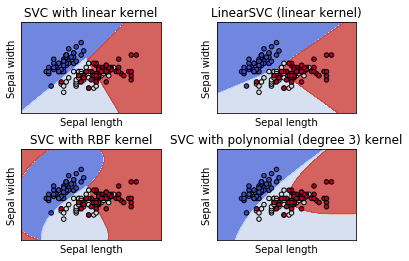

In [8]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()